In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import scipy
from sklearn import preprocessing
from scipy import signal
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import librosa
import pywt
import random
from python_speech_features import mfcc
from python_speech_features import logfbank
from scipy.signal import butter, lfilter

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test


(<timit_utils.core.SubCorpus at 0x156cedf3d30>,
 <timit_utils.core.SubCorpus at 0x156d643ccc0>)

### Split sentences into training and testing data

In [3]:
data_set = []
label_id = []
label_gen = []
label_dem = []
for p in range(len(train.people)):
    count = 0
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(train.person_by_index(p).name)
        label_gen.append(train.person_by_index(p).gender)
        label_dem.append(train.person_by_index(p).region_name)
for p in range(len(test.people)):
    count = 0
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(test.person_by_index(p).name)
        label_gen.append(test.person_by_index(p).gender)
        label_dem.append(test.person_by_index(p).region_name)
num_speakers = len(set(label_id))
print('Number of speakers in data: ', num_speakers)

Number of speakers in data:  630


In [4]:
le1 = preprocessing.LabelEncoder()
le1.fit(label_id)
label_id = le1.transform(label_id)
le2 = preprocessing.LabelEncoder()
le2.fit(label_gen)
label_gen = le2.transform(label_gen)
le3 = preprocessing.LabelEncoder()
le3.fit(label_dem)
label_dem = le3.transform(label_dem)

N = 100 # number of speakers being considered
sub_data_set = []
sub_label_id = []
sub_label_gen = []
sub_label_dem = []
speak_ind = []
for ind1 in range(N):
    ind2 = np.random.randint(630, size=1)
    while ind2[0] in speak_ind is False:
        ind2 = np.random.randint(630, size=1)
    speak_ind.append(ind2[0])
act_ind = []
for ID in speak_ind:
    act_ind= np.where(label_id == ID)
    sub_data_set = sub_data_set+data_set[act_ind[0][0]:act_ind[0][-1]+1]
    sub_label_id = sub_label_id+label_id[act_ind[0]].tolist()
    sub_label_gen = sub_label_gen+label_gen[act_ind[0]].tolist()
    sub_label_dem = sub_label_dem+label_dem[act_ind[0]].tolist()

In [5]:
sentence_lengths = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence_lengths.append(len(train.person_by_index(p).sentence_by_index(s).raw_audio))
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence_lengths.append(len(test.person_by_index(p).sentence_by_index(s).raw_audio))

In [6]:
fs = 16000
wlen = 0.02
num_train_per_test = 3 # for every 3 training sentences, there is 1 testing sentence
training_set = []
training_label_id = []
training_label_gen = []
training_label_dem = []
testing_set = []
testing_label_id = []
testing_label_gen = []
testing_label_dem = []
for ID in set(sub_label_id):
    person_ind = [i for i, x in enumerate(sub_label_id) if x == ID]
    for i, sent_per_ID in enumerate(person_ind):
        if i%(num_train_per_test+1) == 0:
            testing_set.append(sub_data_set[sent_per_ID])
            testing_label_id.append(sub_label_id[sent_per_ID])
            testing_label_gen.append(sub_label_gen[sent_per_ID])
            testing_label_dem.append(sub_label_dem[sent_per_ID])
        else:
            training_set.append(sub_data_set[sent_per_ID])
            training_label_id.append(sub_label_id[sent_per_ID])
            training_label_gen.append(sub_label_gen[sent_per_ID])
            training_label_dem.append(sub_label_dem[sent_per_ID])

len_samps = 1 # length of samples in seconds
ave_seconds_per_ID = sum(sentence_lengths)/(fs*len(sentence_lengths))*10
num_samps_per_ID = round(ave_seconds_per_ID)*10
num_samps_per_ID_test = round(num_samps_per_ID*(1/(num_train_per_test+1)))
num_samps_per_ID_train = num_samps_per_ID-num_samps_per_ID_test
training_data = []
training_l_id = []
training_l_gen = []
training_l_dem = []
testing_data = []
testing_l_id = []
testing_l_gen = []
testing_l_dem = []
for ID_i, ID in enumerate(set(sub_label_id)):
    train_person_ind = [i for i, x in enumerate(training_label_id) if x == ID]
    test_person_ind = [i for i, x in enumerate(testing_label_id) if x == ID]
    for samp in range(num_samps_per_ID_train):
        sent = random.choice(train_person_ind)
        while len(training_set[sent]) < round(fs*len_samps):
            sent = random.choice(train_person_ind)
        start_i = random.randint(0,len(training_set[sent])-round(fs*len_samps))
        training_data.append(training_set[sent][start_i:start_i+round(fs*len_samps)])
        training_l_id.append(ID_i)
        training_l_gen.append(training_label_gen[sent])
        training_l_dem.append(training_label_dem[sent])
    for samp in range(num_samps_per_ID_test):
        sent = random.choice(test_person_ind)
        while len(testing_set[sent]) < round(fs*len_samps):
            sent = random.choice(test_person_ind)
        start_i = random.randint(0,len(testing_set[sent])-round(fs*len_samps))
        testing_data.append(testing_set[sent][start_i:start_i+round(fs*len_samps)])
        testing_l_id.append(ID_i)
        testing_l_gen.append(testing_label_gen[sent])
        testing_l_dem.append(testing_label_dem[sent])

In [7]:
def get_filterbank(data,fs,wlen,nfilt):
    logfbank_es = logfbank(data,samplerate=fs,winlen=wlen,nfilt=nfilt)
    logfbank_es = (logfbank_es-np.mean(logfbank_es))/np.std(logfbank_es)
    return logfbank_es

### Train & test model

In [8]:
class ResBlock(nn.Module):
    def __init__(self,hidden_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels,kernel_size=3,stride=1,padding=1,bias=True)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels, kernel_size=3, stride=1,padding=1,bias=True)
        self.bn2 = nn.BatchNorm2d(hidden_channels)

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = F.leaky_relu(y,0)
        y = self.conv2(y)
        y = self.bn2(y)
        y = F.leaky_relu(y+x,0)
        return y

class ResNet(nn.Module):
    def __init__(self,in_channels,hidden_channels,num_speakers,num_regions):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=hidden_channels,kernel_size=5,stride=2,padding=0,bias=True)
        self.resblock = ResBlock(hidden_channels)
        self.fc = nn.Linear(in_features=hidden_channels*24*15,out_features=num_speakers)
        self.fc2 = nn.Linear(in_features=hidden_channels*24*15,out_features=2)
        self.fc3 = nn.Linear(in_features=hidden_channels*24*15,out_features=num_regions)

    def forward(self, x):
        x = F.relu(self.conv1(x),0)
        x = F.max_pool2d(x,2)
        x = self.resblock(x)
        x = x.view(x.size(0),-1)
        y1 = self.fc(x)
        y2 = self.fc2(x)
        y3 = self.fc3(x)
        return y1, y2, y3

In [9]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    model.double()
    for batch_idx, (data, target1, target2, target3) in enumerate(train_loader):
        data, target1, target2, target3=data.to(device), target1.to(device), target2.to(device), target3.to(device)
        data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
        optimizer.zero_grad()
        output1, output2, output3 = model(data)
        loss = (0.9*criterion(output1, target1))+(0.05*criterion(output2, target2))+(0.05*criterion(output3, target3)) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    model.double()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target1, target2, target3 in test_loader:
            data, target1, target2, target3=data.to(device), target1.to(device), target2.to(device), target3.to(device)
            data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
            output1, output2, output3 = model(data)
            test_loss += criterion(output1, target1).item() # sum up batch loss
            pred = output1.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target1.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))

In [11]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'],nesterov=True)
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [ ]:
cf_array = [200,500,1000,2000,3000,4000,8000]
performances = []
for cf in cf_array:
    perf = []
    print('Cutoff Frequency is {}.'.format(cf))
    batch_size = 5
    train_loader,test_loader = {},{}
    train_list = []
    for ind, data in enumerate(training_data):
        if cf == 8000:
            d = training_data[ind]
        else:
            b, a = butter(10, cf/(fs/2), btype='low', analog=False)
            d = lfilter(b,a,training_data[ind])
        data = get_filterbank(d,fs,wlen,64)
        train_list.append((data, training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
    test_list = []
    for ind, data in enumerate(testing_data):
        if cf == 8000:
            d = testing_data[ind]
        else:
            b, a = butter(10, cf/(fs/2), btype='low', analog=False)
            d = lfilter(b,a,testing_data[ind])
        data = get_filterbank(d,fs,wlen,64)
        test_list.append((data, testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))
    train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)
    print('Done with calculating spectrograms.')

    seed = 1
    device = 'cpu'
    data_name = 'timit'
    optimizer_name = 'SGD'
    scheduler_name = 'MultiStepLR'
    num_epochs = 15
    lr = 0.005
    device = torch.device(device)
    torch.manual_seed(1)
    in_channels = 1
    out_channels = N
    model = ResNet(in_channels, out_channels, N, 8).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0.5, weight_decay=0)
    scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5,10,15], factor=0.1)
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader[data_name], criterion, optimizer, epoch)
        l = test(model, device, test_loader[data_name], criterion, epoch)
        perf.append(l)
        scheduler.step()
        print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
    performances.append(perf)

Cutoff Frequency is 200.
Done with calculating spectrograms.
Train(1)[0%]: Loss: 4.3597
Train(1)[50%]: Loss: 3.6626
Test(1): Loss: 3.4977, Accuracy: 12.8894%
Optimizer Learning rate: 0.0050
Train(2)[0%]: Loss: 3.9381
Train(2)[50%]: Loss: 2.2039
Test(2): Loss: 3.2988, Accuracy: 18.3209%
Optimizer Learning rate: 0.0050
Train(3)[0%]: Loss: 0.9519
Train(3)[50%]: Loss: 1.5386
Test(3): Loss: 3.1960, Accuracy: 22.1533%
Optimizer Learning rate: 0.0050
Train(4)[0%]: Loss: 1.2731
Train(4)[50%]: Loss: 1.0030
Test(4): Loss: 3.4489, Accuracy: 21.6570%
Optimizer Learning rate: 0.0050
Train(5)[0%]: Loss: 0.9688
Train(5)[50%]: Loss: 0.5880
Test(5): Loss: 3.8103, Accuracy: 24.8553%
Optimizer Learning rate: 0.0005
Train(6)[0%]: Loss: 0.8191
Train(6)[50%]: Loss: 0.2225
Test(6): Loss: 3.8094, Accuracy: 28.0535%
Optimizer Learning rate: 0.0005
Train(7)[0%]: Loss: 0.1058
Train(7)[50%]: Loss: 0.1432
Test(7): Loss: 3.9385, Accuracy: 27.9708%
Optimizer Learning rate: 0.0005
Train(8)[0%]: Loss: 0.1102
Train(8)[

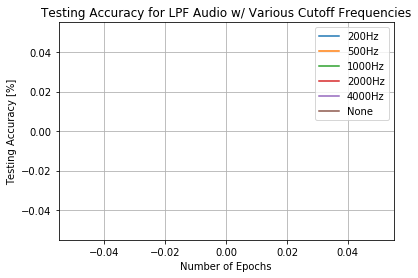

In [88]:
for i in range(len(performances)):
    plt.plot(performances[i])
plt.show
plt.title('Testing Accuracy for LPF Audio w/ Various Cutoff Frequencies')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing Accuracy [%]')
plt.legend(['200Hz','500Hz','1000Hz','2000Hz','3000Hz','4000Hz','None'])
plt.grid(True)